## Task-2 - GradCAM and Occlusion
A cool task for the above model is to learn how different features are extracted by model in each layer . To do this we will using GradCAM and Occlusion methods.

### GradCAM
GradCAM uses the gradients of the target class w.r.t. the feature maps of a CNN layer to compute importance weights. In this exercise we want you to generate visulaizations and write short notes on your understanding on how each layer contributes to the final classification result. You should also display overlay of heat maps of feature vectors on the image to support your understanding of the model’s behavior.

### Occlusion
Occlusion ( occlusion sensitivity) is a simple but powerful interpretability technique for CNNs. Essentially, we make the model freak out by masking the input image but in specific small patches. You take an input image and systematically mask (occlude) different parts of it (e.g., by placing a gray or black square patch over a region). For each occluded version of the image, you run it through the CNN and record how much the model’s prediction score for the target class changes.

### The idea:

- If covering a region makes the score drop a lot, that region is important for the decision.
- If covering it barely changes the score, it’s less relevant.
- For submission you will require to submit the accuracy score with at least 3 different occlusion masks and heatmap plot for each mask

In [ ]:
!pip install captum datasets --quiet

### Import Libraries
Import PyTorch, data loading tools, Captum for interpretability, and visualization libraries.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from datasets import load_dataset
from captum.attr import LayerGradCam, LayerAttribution, Occlusion
import matplotlib.cm as cm
import os
import math

### Load and Prepare Dataset
Load the cats vs dogs dataset and create training/test splits with appropriate transforms.


In [ ]:
ds = load_dataset("pantelism/cats-vs-dogs")

train_test_split = ds['train'].train_test_split(test_size=0.2, seed=42)
train_ds = train_test_split['train']
test_ds = train_test_split['test']

class CustomDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image']
        label = item['label']

        if self.transform:
            image = self.transform(image)

        return image, label

train_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

test_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = CustomDataset(train_ds, transform=train_tf)
test_dataset = CustomDataset(test_ds, transform=test_tf)

num_epochs = 20
learning_rate = 0.0005
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


dogs-vs-cats-subset.zip:   0%|          | 0.00/90.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4000 [00:00<?, ? examples/s]

### Define and Load Model
Define the SimpleCNN architecture with residual blocks and load the pre-trained weights.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "cnn_weights.pth"

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        return F.relu(out + x)

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2, p_drop=0.5):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1, bias=False), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1, bias=False), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
            ResidualBlock(128),
            nn.Conv2d(128, 256, 3, padding=1, bias=False), nn.BatchNorm2d(256), nn.ReLU(), nn.MaxPool2d(2),
            ResidualBlock(256),
            nn.Conv2d(256, 512, 3, padding=1, bias=False), nn.BatchNorm2d(512), nn.ReLU(), nn.MaxPool2d(2),
            ResidualBlock(512),
            nn.Conv2d(512, 512, 3, padding=1, bias=False), nn.BatchNorm2d(512), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(p_drop)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        return self.fc(x)

model = SimpleCNN()
obj = torch.load(MODEL_PATH, map_location=device)
if isinstance(obj, dict):
    model.load_state_dict(obj, strict=False)
else:
    model = obj
model.to(device).eval()

print("model loaded")


model loaded


### Select and Predict on Test Image
Select a random image from the dataset, preprocess it, and make a prediction to use for interpretability analysis.


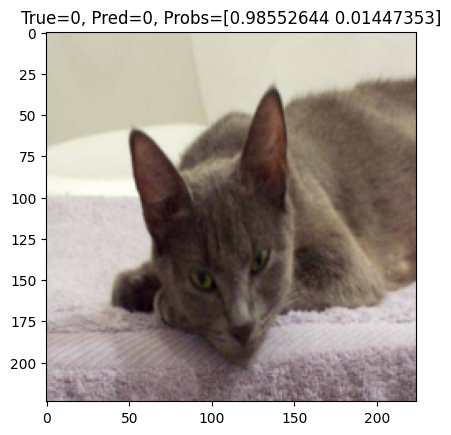

prediction: True=0, Pred=0, Probs=[0.98552644 0.01447353]


In [ ]:
IMG_SIZE = 224
infer_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

vis_tfms = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE))])

idx = np.random.randint(0, len(ds["train"]))
ex = ds["train"][idx]
img = ex["image"].convert("RGB")
true_label = int(ex["label"])

x = infer_tfms(img).unsqueeze(0).to(device)
x_vis = np.array(vis_tfms(img))

with torch.no_grad():
    out = model(x)
    probs = torch.softmax(out, dim=1).squeeze().cpu().numpy()
pred_label = int(np.argmax(probs))

plt.imshow(x_vis)
plt.title(f"True={true_label}, Pred={pred_label}, Probs={probs}")
plt.show()

print(f"prediction: True={true_label}, Pred={pred_label}, Probs={probs}")


### GradCAM Visualization
Generate GradCAM heatmaps for all convolutional layers to visualize which regions the model focuses on at different layers.


Found 5 convolutional layers.


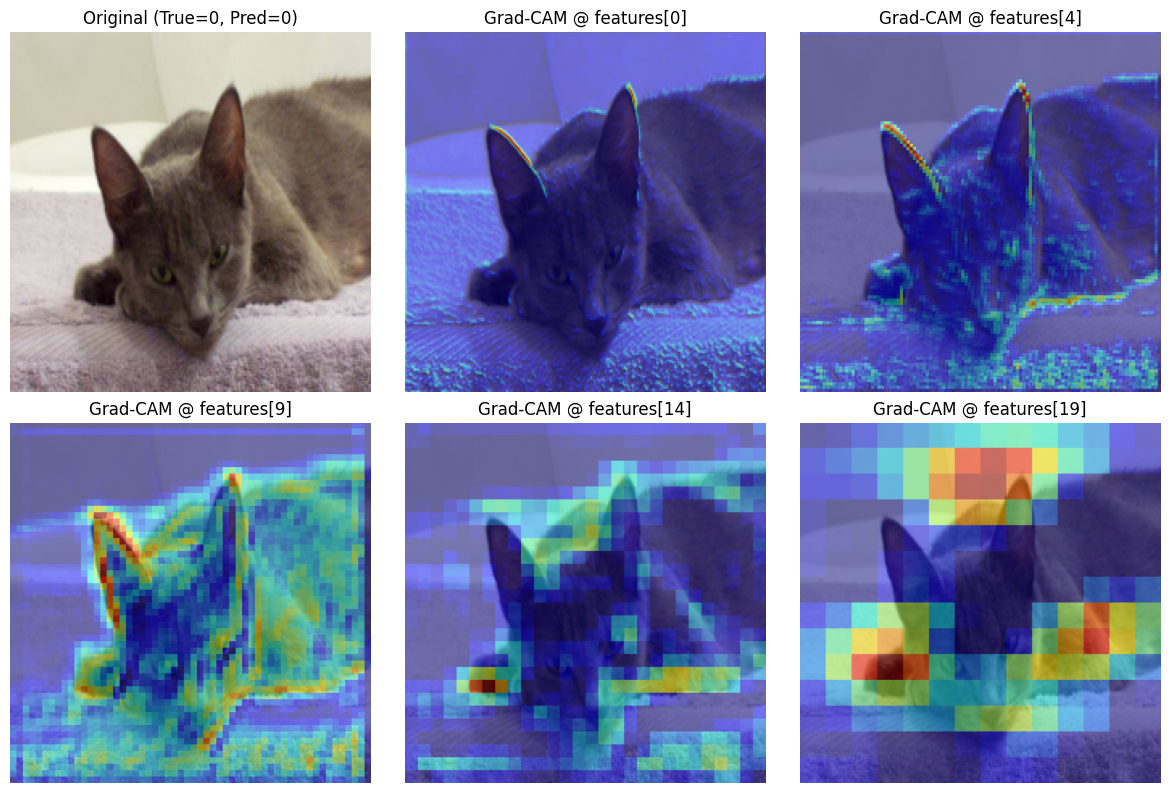

In [ ]:
def gradcam_for_layer(model, layer, x, target_class):
    gradcam = LayerGradCam(model, layer)
    attr = gradcam.attribute(x, target=target_class)
    cam = LayerAttribution.interpolate(attr, x.shape[-2:])
    cam = cam.squeeze(0).mean(0).cpu().detach().numpy()
    cam = np.maximum(cam, 0)
    cam -= cam.min()
    if cam.max() > 0: cam /= cam.max()
    return cam

def overlay_heatmap(img_np, heatmap, alpha=0.5):
    colored = cm.jet(heatmap)[..., :3]
    overlay = (1 - alpha) * img_np / 255.0 + alpha * colored
    return np.clip(overlay, 0, 1)

layer_ids = [i for i in range(len(model.features)) if isinstance(model.features[i], nn.Conv2d)]
layers = [model.features[i] for i in layer_ids]

num_layers = len(layers)
print(f"Found {num_layers} convolutional layers.")

cols = math.ceil((num_layers + 1) / 2.0)
rows = 2

fig, axs = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))

if rows > 1:
    axs = axs.flatten()

axs[0].imshow(x_vis); axs[0].set_title(f"Original (True={true_label}, Pred={pred_label})")
axs[0].axis("off")

for i, layer in enumerate(layers, start=1):
    cam = gradcam_for_layer(model, layer, x, target_class=pred_label)
    overlay = overlay_heatmap(x_vis, cam)
    axs[i].imshow(overlay)
    axs[i].set_title(f"Grad-CAM @ features[{layer_ids[i-1]}]")
    axs[i].axis("off")

for j in range(num_layers + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

### Occlusion Sensitivity Analysis
Perform occlusion sensitivity analysis by masking important regions and visualizing the impact on model predictions with GradCAM heatmaps for 3 different occlusion locations.


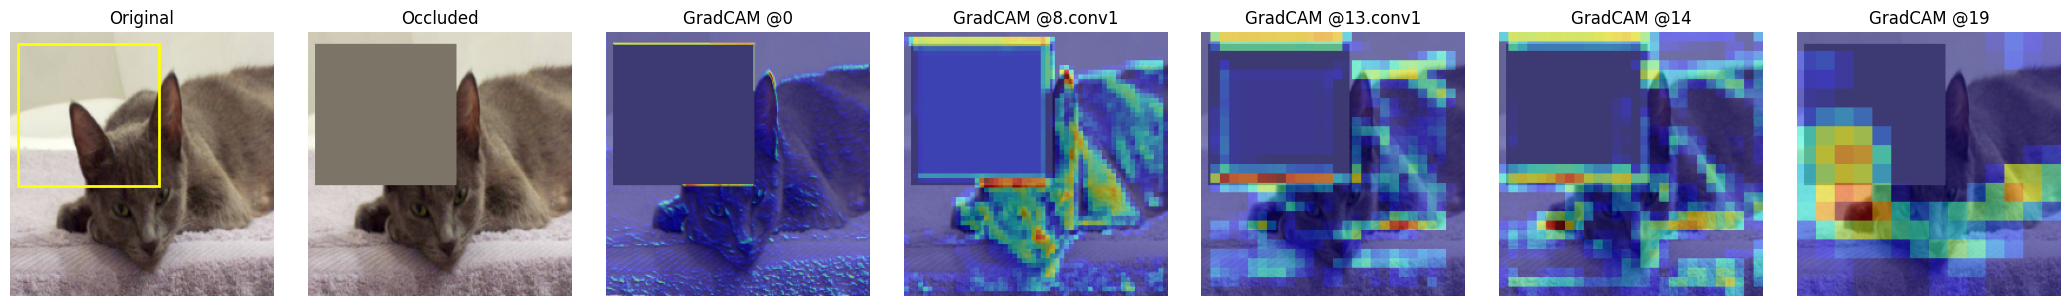

Location 1: Confidence 0.986 → 0.816 (Δ -0.169)


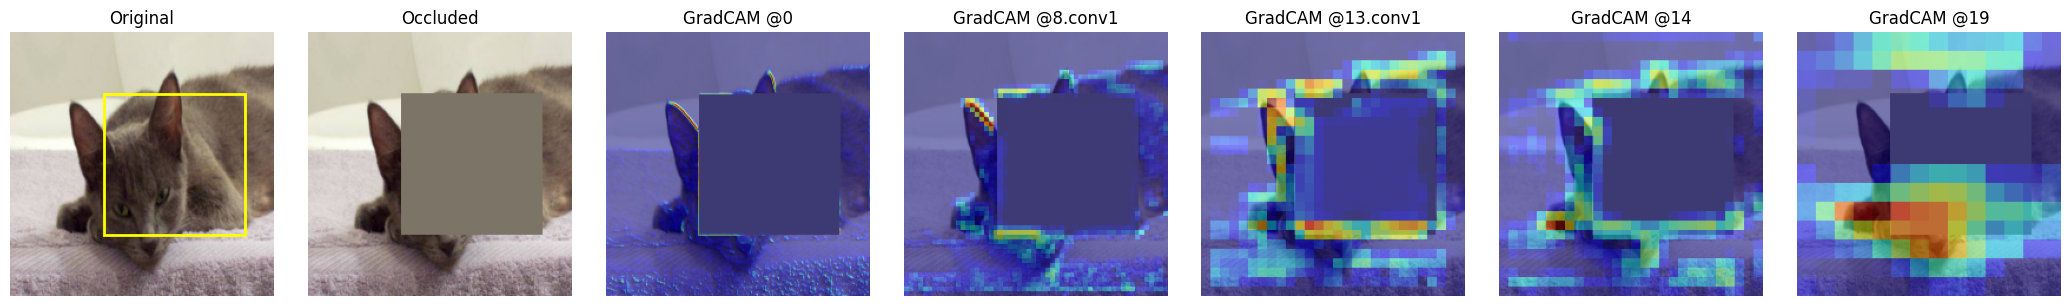

Location 2: Confidence 0.986 → 0.932 (Δ -0.054)


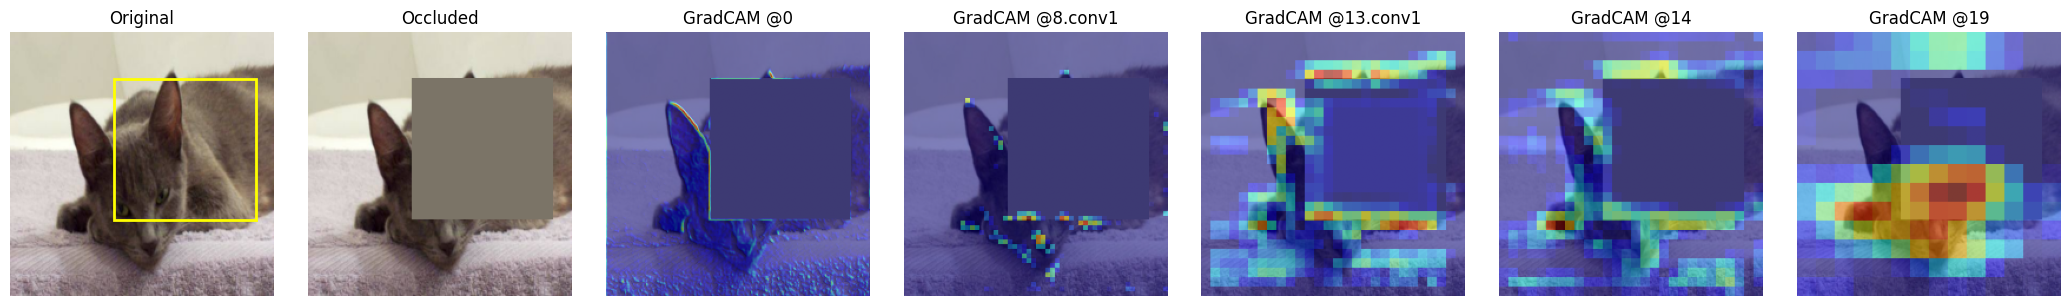

Location 3: Confidence 0.986 → 0.951 (Δ -0.034)


In [ ]:
import matplotlib.patches as patches

device = next(model.parameters()).device
model.eval()

def get_all_convs(m):
    return [(n, mod) for n, mod in m.named_modules() if isinstance(mod, nn.Conv2d)]

def pick_layers(m, k=3):
    convs = get_all_convs(m)
    idxs = np.linspace(0, len(convs)-1, num=k, dtype=int)
    return [convs[i] for i in idxs]

def random_patch_locations(img_size, patch, k=3):
    H, W = img_size
    locs = []
    for _ in range(k):
        top = np.random.randint(0, max(1, H - patch))
        left = np.random.randint(0, max(1, W - patch))
        locs.append((top, left))
    return locs

def apply_one_patch(x, top, left, patch, baseline=0.0):
    x2 = x.clone()
    x2[:, :, top:top+patch, left:left+patch] = baseline
    return x2

def tensor_to_uint8_img(xn):
    x_ = xn.detach().cpu().clone()
    mean = torch.tensor([0.485,0.456,0.406]).view(1,3,1,1)
    std  = torch.tensor([0.229,0.224,0.225]).view(1,3,1,1)
    x_ = (x_ * std + mean).clamp(0,1)
    return (x_[0].permute(1,2,0).numpy() * 255).astype(np.uint8)

with torch.no_grad():
    base_logits = model(x)
    base_probs = torch.softmax(base_logits, dim=1).squeeze().cpu().numpy()
    pred_label = int(np.argmax(base_probs))

rep_layers = pick_layers(model.features, k=5)
patch = 120
target_cls = pred_label

locs = random_patch_locations((IMG_SIZE, IMG_SIZE), patch, k=3)

for i, (top, left) in enumerate(locs, start=1):
    x_occ = apply_one_patch(x, top, left, patch, baseline=0.0)
    x_vis_occ = tensor_to_uint8_img(x_occ)

    with torch.no_grad():
        occ_logits = model(x_occ)
        occ_probs = torch.softmax(occ_logits, dim=1).squeeze().cpu().numpy()

    fig, axs = plt.subplots(1, 7, figsize=(21, 3))
    axs[0].imshow(x_vis)
    axs[0].add_patch(patches.Rectangle((left, top), patch, patch, ec='yellow', fc='none', lw=2))
    axs[0].set_title(f"Original"); axs[0].axis("off")
    axs[1].imshow(x_vis_occ); axs[1].set_title("Occluded"); axs[1].axis("off")

    for j, (lname, layer) in enumerate(rep_layers):
        cam = gradcam_for_layer(model, layer, x_occ, target_class=target_cls)
        over = overlay_heatmap(x_vis_occ, cam)
        axs[2+j].imshow(over)
        axs[2+j].set_title(f"GradCAM @{lname.replace('features.','')}")
        axs[2+j].axis("off")

    plt.tight_layout(); plt.show()

    print(f"Location {i}: Confidence {base_probs[target_cls]:.3f} → {occ_probs[target_cls]:.3f} (Δ {occ_probs[target_cls] - base_probs[target_cls]:+.3f})")


### Discussion on Occlusion and GradCAM

Using Occlusion and GradCAM together helps us understand how the CNN makes its decisions. When we cover an important part of the image, like the animal’s face, the model’s confidence drops a lot and GradCAM shows that its focus becomes scattered, meaning it can no longer find the right features. But when we hide less important parts, such as the background, the confidence doesn’t change much and the heatmaps still highlight the main areas, showing that the model knows what’s important. Sometimes, covering confusing parts even helps the model focus better on clearer features. Overall, this shows that by looking at how confidence changes and where the model focuses, we can reason about how it “thinks,” how stable its predictions are, and where it might get confused.